In [1]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

In [2]:
data_folder = 'data/thomsonlab_signaling/'
large_data_folder = 'large_data/thomsonlab_signaling/'
fig_folder = 'figure/thomsonlab_signaling/'

In [3]:
cadata = ad.read_h5ad(large_data_folder + 'thomsonlab_signaling_filtered_2500_scvi_umap.h5ad')

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
seed = 0
num_spin = 20
num_pool = num_spin
num_repeat = 10
task_name = "thomsonlab_signaling"
save_path = "./test/test_signalling/"

## Test with DSPIN Class

In [5]:
from util.dspin import DSPIN

In [35]:
# Reload the Package
from importlib import reload
import util.dspin  
reload(util.dspin)  
from util.dspin import DSPIN 

In [36]:
a = DSPIN(cadata, save_path, num_spin)

/Users/ygong/git/DSPIN-abstract/util/dspin.py:76: UserWarning: num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.
  warnings.warn("num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.")


In [41]:
a.gene_program_csv = 'test/test_signalling/onmf_gene_list_20.csv'

Discretize ONMF representation into three states


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


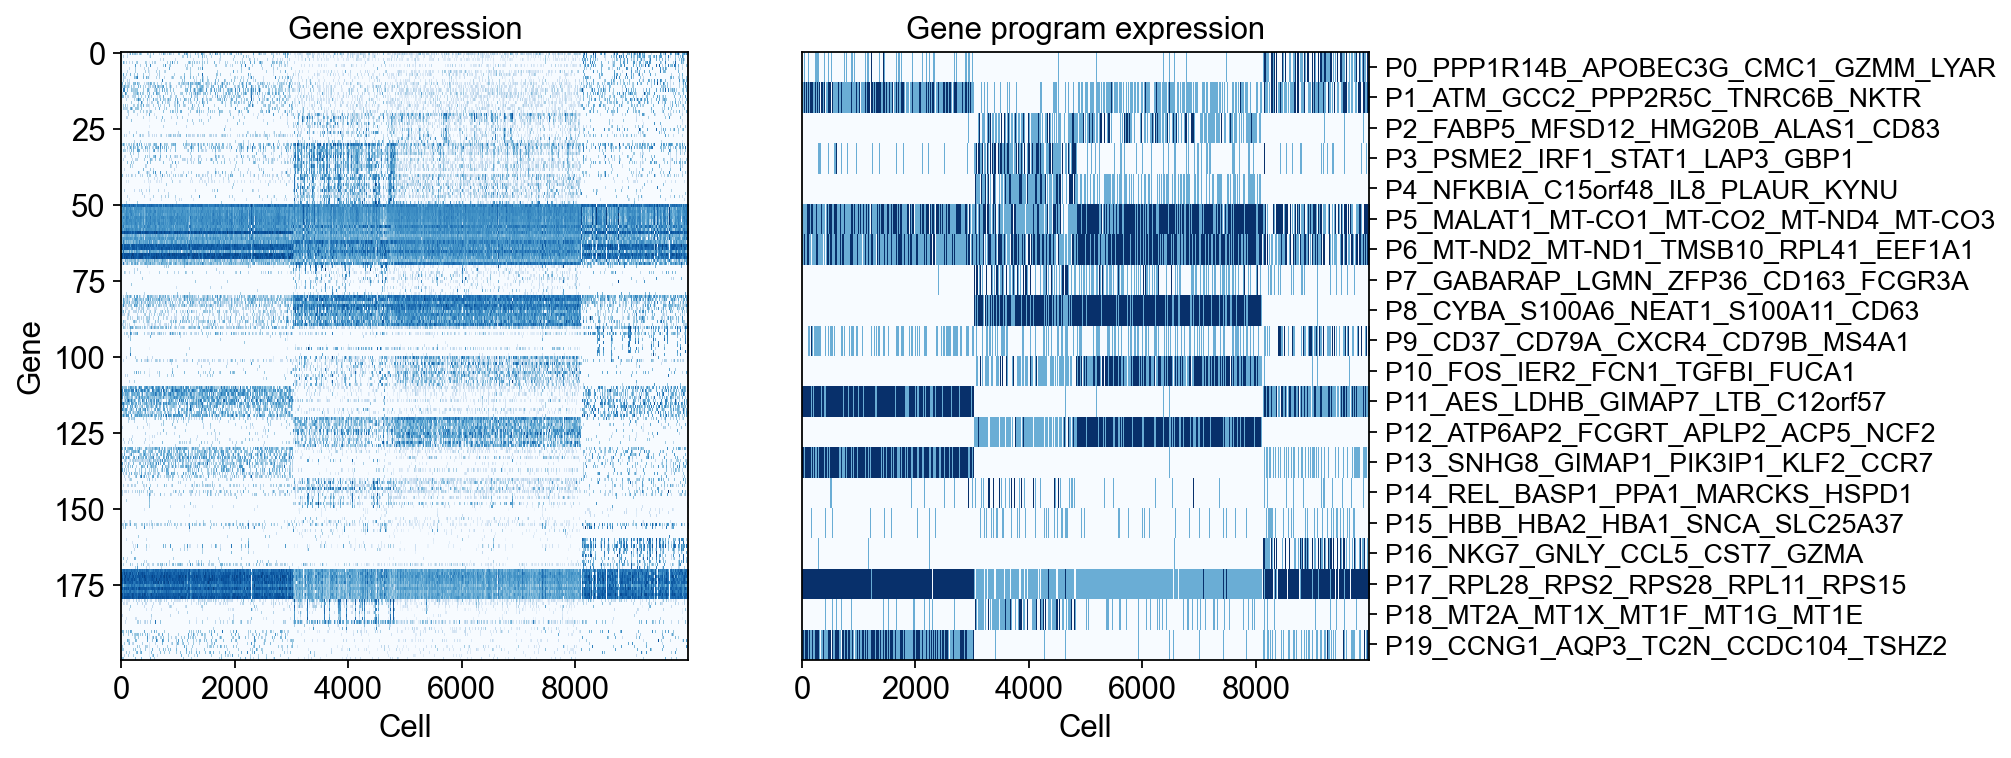

In [42]:
a.gene_program_discovery(sample_column_name= 'sample_batch')

In [43]:
example_list = ['TNFA_200ng_mL_1-COVID-1', 'IL7_50ng_mL_1-COVID-1', 'LPS_50ng_mL_1-COVID-1', 'CCL2_200ng_mL_1-COVID-1', 'CONTROL_1-COVID-1']

In [44]:
a.network_infer(example_list=example_list)

Progress: 13, Network gradient: 9.832556
Progress: 20, Network gradient: 8.553458
Progress: 26, Network gradient: 7.567266
Progress: 33, Network gradient: 6.842499
Progress: 40, Network gradient: 6.141459
Progress: 46, Network gradient: 5.550900
Progress: 53, Network gradient: 5.035094
Progress: 60, Network gradient: 4.551943
Progress: 66, Network gradient: 4.174592
Progress: 73, Network gradient: 3.833870
Progress: 80, Network gradient: 3.515456
Progress: 86, Network gradient: 3.248665
Progress: 93, Network gradient: 3.012269
Progress: 100, Network gradient: 2.823600


### Directly Load onmf Summary

In [37]:
onmf_summary = np.load('test/test_signalling/onmf_summary_20.npy', allow_pickle=True).item()

In [38]:
a.onmf_summary = onmf_summary

In [9]:
a.matrix_balance()

### Verification the Correctness of ONMF Representation

In [ ]:
from util.plotting import onmf_gene_program_info

num_gene_show = 20
features = a.onmf_summary.components_
gene_name = cadata.var_names

onmf_gene_program_info(features, gene_name, num_gene_show, fig_folder)

#### Visualization of gene program decomposition

In [39]:
from importlib import reload
import util.compute
reload(util.compute)   

<module 'util.compute' from '/Users/ygong/git/DSPIN-abstract/util/compute.py'>

In [10]:
a.compute_onmf_rep_ori()

In [11]:
a.discretize()

100%|██████████| 20/20 [00:03<00:00,  6.56it/s]


In [12]:
a.onmf_rep_tri

array([[0. , 0. , 0. , ..., 1. , 0. , 0.5],
       [1. , 0. , 0. , ..., 1. , 0. , 0.5],
       [0.5, 0.5, 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0.5, 0.5, ..., 0.5, 0. , 0. ],
       [0. , 0.5, 0. , ..., 0.5, 0.5, 0. ],
       [0. , 0.5, 0.5, ..., 0.5, 0. , 0. ]])

In [13]:
onmf_rep_tri = a.onmf_rep_tri

In [14]:
from util.plotting import temporary_spin_name, gene_program_decomposition

In [47]:
spin_name = temporary_spin_name('test/test_signalling/onmf_gene_list_20.csv')

In [17]:
fig_folder = '/Users/ygong/git/DSPIN-abstract/test/test_signalling/figs'

In [19]:
gene_program_decomposition(a.onmf_summary, num_spin, spin_name, a.gene_matrix_large, onmf_rep_tri, fig_folder)

TypeError: tuple indices must be integers or slices, not tuple

In [15]:
gene_matrix = a.gene_matrix_large

In [23]:
std = a.matrix_std

In [45]:
import networkx as nx
import matplotlib.patheffects as patheffects

def plot_jmat_network(G): 
    
    self_loops = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(self_loops)

    eposi= [(u, v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
    wposi= np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] > 0])

    enega = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]
    wnega = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] < 0])

    col1 = '#f0dab1'
    # nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=col1, edgecolors='None')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=node_color, edgecolors='k')

    sig_fun = lambda xx : (1 / (1 + np.exp(- 5 * (xx + cc))))
    cc = np.max(np.abs(j_mat)) / 10
    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=eposi, width=linewz * wposi, 
                            edge_color='#3285CC', alpha=sig_fun(wposi))

    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=enega, width=- linewz * wnega, 
                            edge_color='#E84B23', alpha=sig_fun(- wnega))

    margin = 0.2
    plt.margins(x=0.1, y=0.1)

    ax.set_axis_off()
    ax.set_aspect('equal')
    return ax 

In [48]:
gene_list = spin_name

In [49]:
gene_list

['P0_PPP1R14B_APOBEC3G_CMC1_GZMM_LYAR',
 'P1_ATM_GCC2_PPP2R5C_TNRC6B_NKTR',
 'P2_FABP5_MFSD12_HMG20B_ALAS1_CD83',
 'P3_PSME2_IRF1_STAT1_LAP3_GBP1',
 'P4_NFKBIA_C15orf48_IL8_PLAUR_KYNU',
 'P5_MALAT1_MT-CO1_MT-CO2_MT-ND4_MT-CO3',
 'P6_MT-ND2_MT-ND1_TMSB10_RPL41_EEF1A1',
 'P7_GABARAP_LGMN_ZFP36_CD163_FCGR3A',
 'P8_CYBA_S100A6_NEAT1_S100A11_CD63',
 'P9_CD37_CD79A_CXCR4_CD79B_MS4A1',
 'P10_FOS_IER2_FCN1_TGFBI_FUCA1',
 'P11_AES_LDHB_GIMAP7_LTB_C12orf57',
 'P12_ATP6AP2_FCGRT_APLP2_ACP5_NCF2',
 'P13_SNHG8_GIMAP1_PIK3IP1_KLF2_CCR7',
 'P14_REL_BASP1_PPA1_MARCKS_HSPD1',
 'P15_HBB_HBA2_HBA1_SNCA_SLC25A37',
 'P16_NKG7_GNLY_CCL5_CST7_GZMA',
 'P17_RPL28_RPS2_RPS28_RPL11_RPS15',
 'P18_MT2A_MT1X_MT1F_MT1G_MT1E',
 'P19_CCNG1_AQP3_TC2N_CCDC104_TSHZ2']

In [50]:
cur_j = a.network

In [53]:
j_mat = a.responses

In [66]:
def replace_third_underscore(label):
    parts = label.split('_')
    parts[1] = parts[1] + '\n'
    parts[3] = parts[3] + '\n'
    return '_'.join(parts)

In [67]:
label = 'P0_PPP1R14B_APOBEC3G_CMC1_GZMM_LYAR'
print(replace_third_underscore(label))

P0_PPP1R14B
_APOBEC3G_CMC1
_GZMM_LYAR


In [57]:
def adjust_label_position(pos, offset=0.1):
    """Move labels radially outward from the center by a given offset."""
    adjusted_pos = {}
    for node, coordinates in pos.items():
        theta = np.arctan2(coordinates[1], coordinates[0])
        radius = np.sqrt(coordinates[0]**2 + coordinates[1]**2)
        adjusted_pos[node] = (coordinates[0] + np.cos(theta)*offset, coordinates[1] + np.sin(theta)*offset)
    return adjusted_pos

Text(0.5, 1.0, 'D-SPIN')

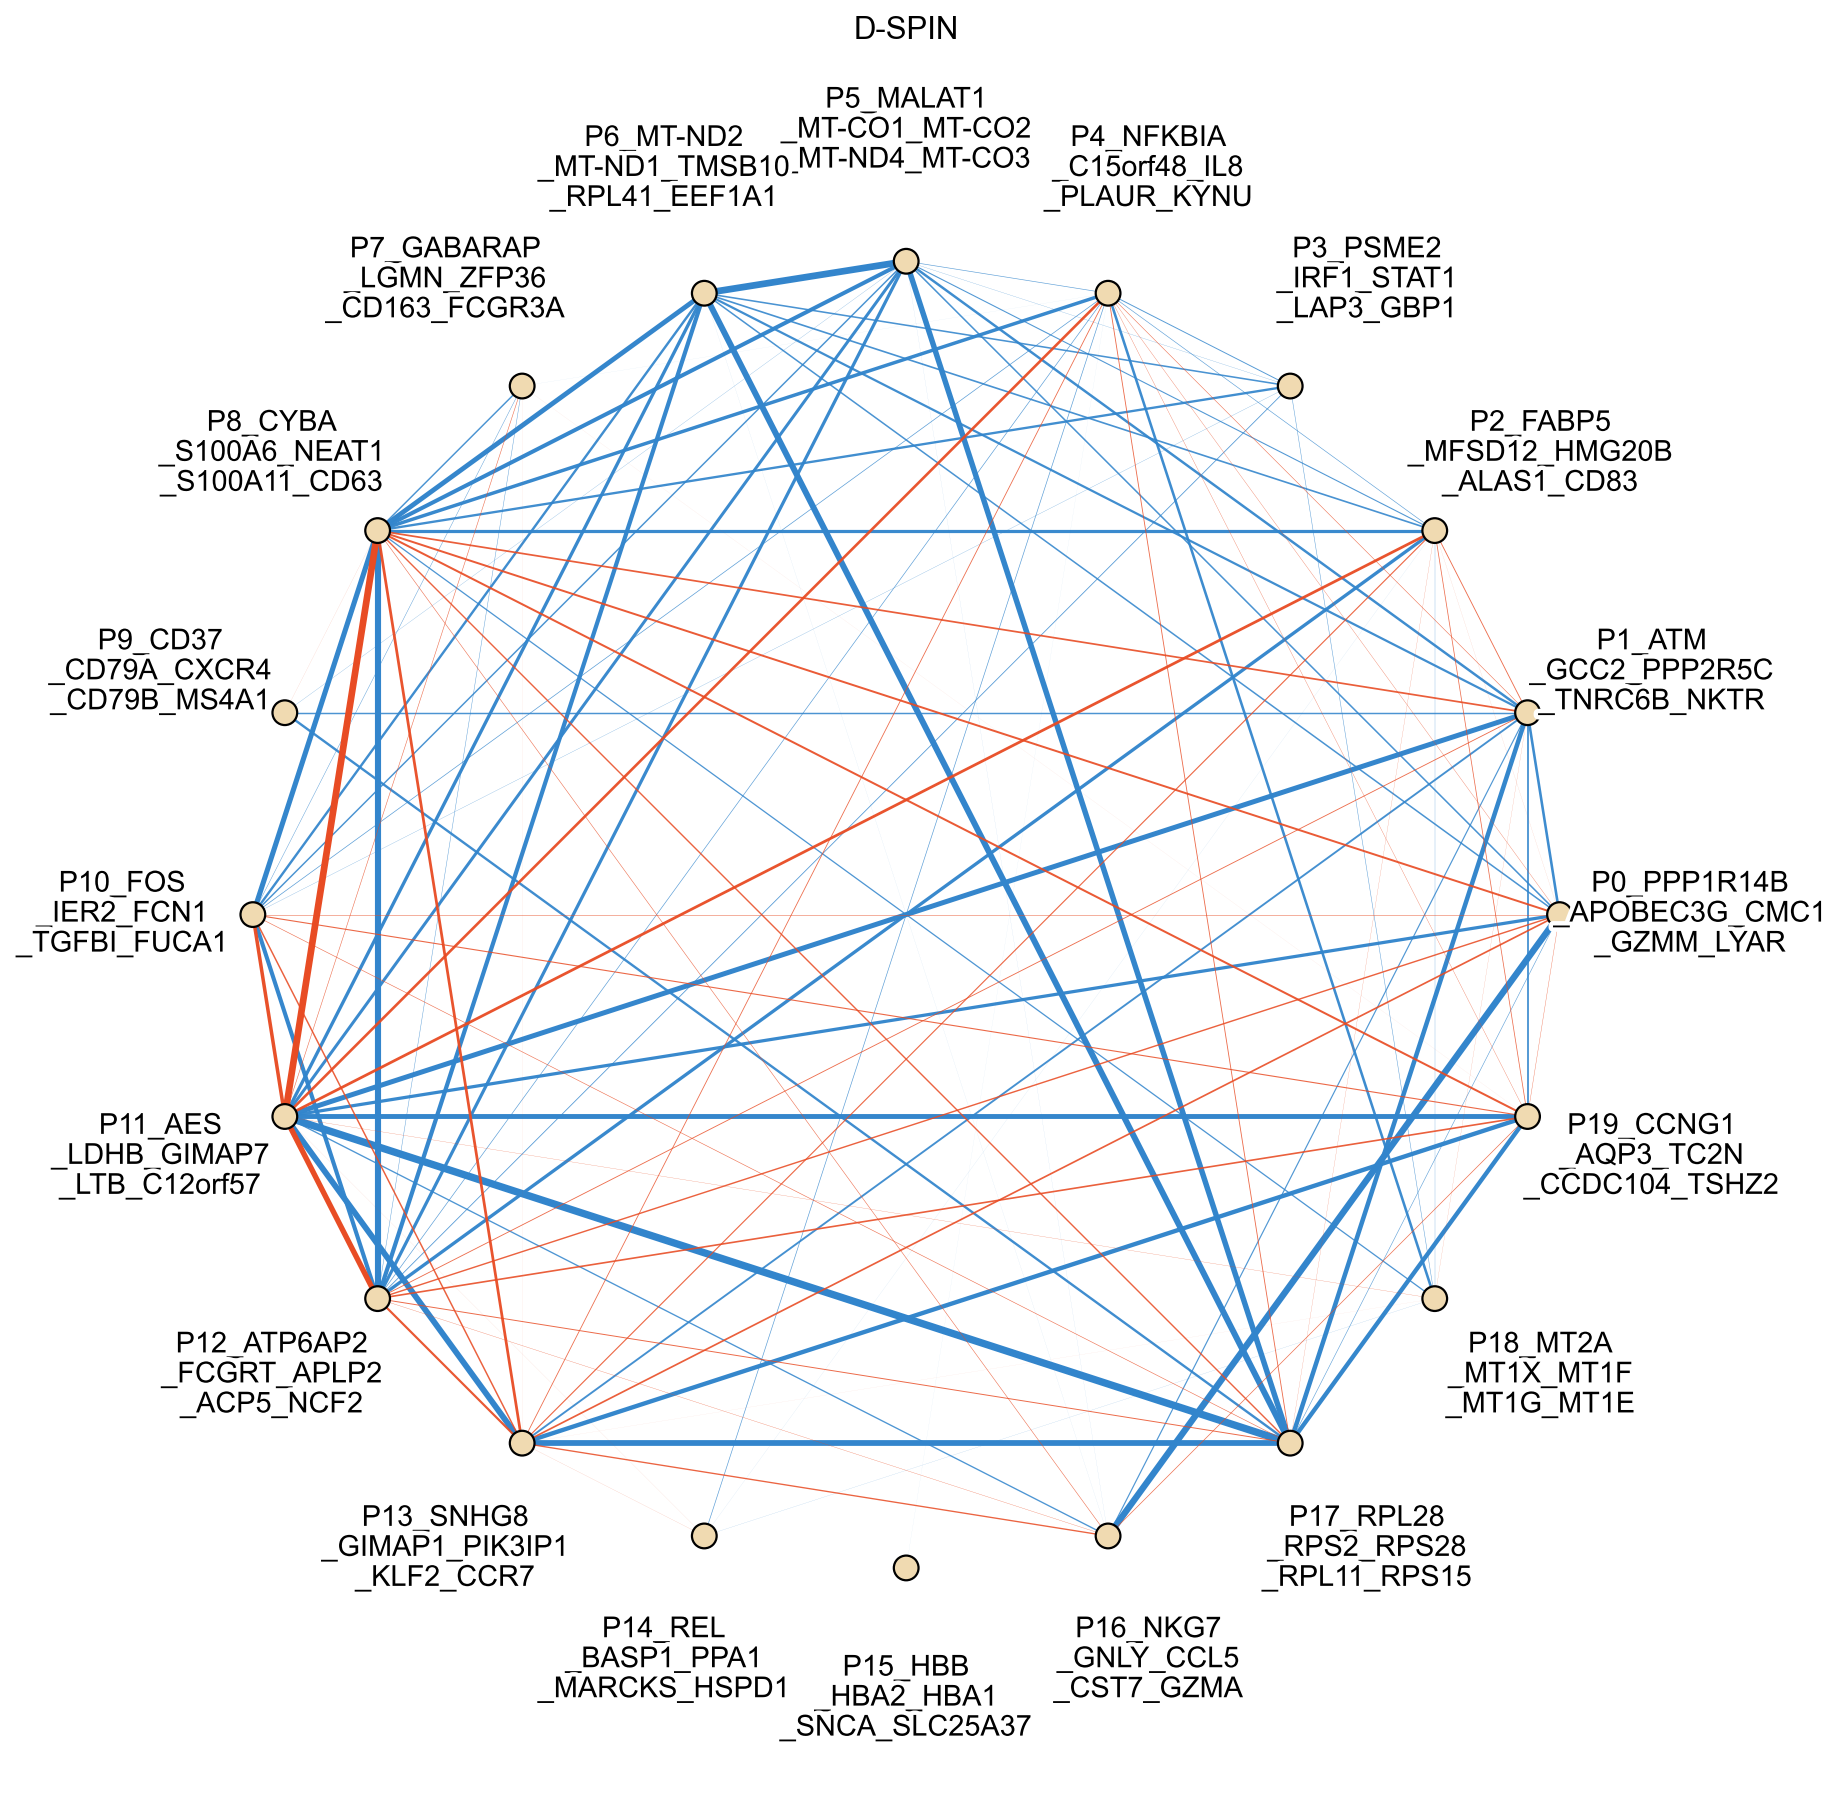

In [68]:
sc.set_figure_params(figsize=[18, 14])

nodesz = 2
linewz = 3
node_color = ['#f0dab1'] * num_spin
node_label = np.array([replace_third_underscore(label) for label in gene_list])


fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt)
pos = nx.circular_layout(G)

ax = plt.subplot(grid[1])
ax = plot_jmat_network(G)

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]

adjusted_positions = adjust_label_position(pos, 0.2)
for ii in range(num_spin):
    x, y = adjusted_positions[ii]
    text = plt.text(x, y, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('D-SPIN')
